/Users/timw/anaconda3/envs/evtools/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


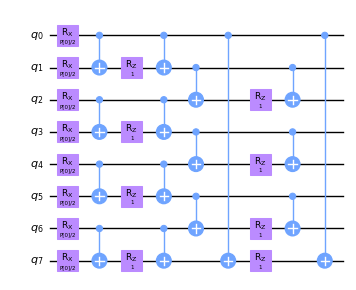

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.opflow import CircuitStateFn
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
import numpy as np
from functools import reduce

I = np.array([[1,0],[0,1]])
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])

J = -1
n_q = 8
pvec = ParameterVector('P', 1)
_qc = QuantumCircuit(n_q)
for i in range(n_q):
    _qc.rx(pvec[0]/2, i)
for i in range(0,n_q,2):
    _qc.cx(i,i+1)
    _qc.rz(-J,i+1)
    _qc.cx(i,i+1)
for i in range(1,n_q-1,2):
    _qc.cx(i,i+1)
    _qc.rz(-J,i+1)
    _qc.cx(i,i+1)
_qc.cx(0,n_q-1)
_qc.rz(-J,n_q-1)
_qc.cx(0,n_q-1)
_qc.draw('mpl', scale=.5)


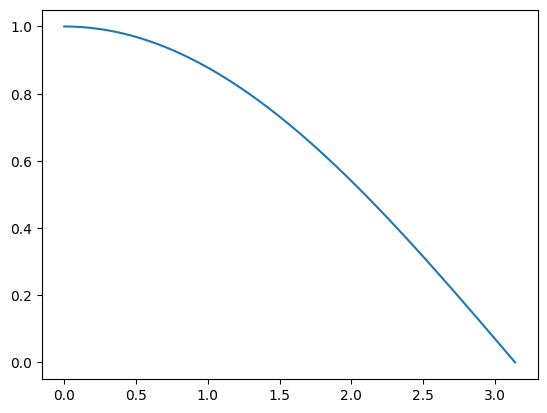

In [3]:
hs = np.linspace(0,np.pi,100)
exact_vals = []
for h in hs:
    qc_temp = _qc.assign_parameters([h])
    psi_temp = Statevector(qc_temp).data.reshape(-1,1)
    Z_obs = reduce(np.kron, [I]*(n_q-1)+[Z])
    exact = (psi_temp.conj().T @ Z_obs @ psi_temp)[0,0].real
    exact_vals.append(exact)
plt.plot(hs, exact_vals)

In [4]:
qc_temp = _qc.assign_parameters([0.1])
psi_temp = Statevector(qc_temp).data.reshape(-1,1)
exact = (psi_temp.conj().T @ Z_obs @ psi_temp)[0,0].real
exact

0.9987502603949677

In [5]:
import sys
from evtools.models.depolarizing import DepolarizingModel

paulistring='I'*(n_q-1)+'Z'
DM = DepolarizingModel(qc_temp)
DM.build_circuit(paulistring)
DM.build_rho()

# Increasing Depolarization Strength

In [6]:
from itertools import product
ps = 1-0.75**np.arange(30)
shots = 2**np.arange(12, 50)
ps_shots = list(product(ps, shots))

In [7]:
ps = 1-0.75**np.arange(30)
shots = 2**np.arange(10, 50)

DM.balance_Y=False

expvals = []
purity  = []
p0      = []
expvals_eps_norm = []
expvals_spectral = []
expvals_unbalanced = []

for ns in shots:
    print(ns)
    _expvals = []
    _purity = []
    _p0 = []
    for p in ps:
        DM.n_samples = ns
        DM.p=p
        DM.estimate_rdm(sampled=True)
        _expvals.append(DM.EV_estimate())
        _purity.append(DM.purity)
        _p0.append(DM.p0)
    expvals.append(_expvals)
    purity.append(_purity)
    p0.append(_p0)
        
expvals = np.array(expvals)
purity = np.array(purity)
p0 = np.array(p0)

quad = (2*purity-1+np.sqrt(2*purity-1))/(1-purity)
eps = DM.d * p0 / (2 + quad)
expvals_mitigated = expvals * (1 + 2*eps/(DM.d*(1-eps)))

1024
2048
4096
8192
16384
32768
65536
131072
262144
524288
1048576
2097152
4194304
8388608
16777216
33554432
67108864
134217728
268435456
536870912
1073741824
2147483648
4294967296
8589934592
17179869184
34359738368
68719476736
137438953472
274877906944
549755813888
1099511627776
2199023255552
4398046511104
8796093022208
17592186044416
35184372088832
70368744177664
140737488355328
281474976710656
562949953421312


/var/folders/wm/j6qnbfdn5sg3xfy711dv5jzw0000gn/T/ipykernel_41883/2573818799.py:33: RuntimeWarning: divide by zero encountered in divide
  quad = (2*purity-1+np.sqrt(2*purity-1))/(1-purity)
/var/folders/wm/j6qnbfdn5sg3xfy711dv5jzw0000gn/T/ipykernel_41883/2573818799.py:33: RuntimeWarning: invalid value encountered in divide
  quad = (2*purity-1+np.sqrt(2*purity-1))/(1-purity)


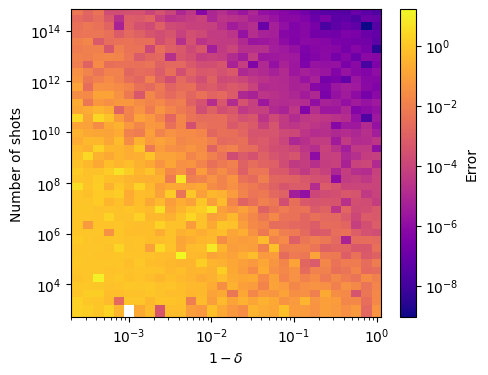

In [8]:
from matplotlib.colors import LogNorm
from matplotlib import cm, ticker

fig, ax = plt.subplots(figsize=(5,4))

errors = abs(expvals_mitigated-exact)


cs = ax.pcolormesh(1-ps, shots, errors, cmap=cm.plasma,
    norm=LogNorm(vmin=errors[~np.isnan(errors)].min(), 
                 vmax=errors[~np.isnan(errors)].max()
                 )
)
cb = fig.colorbar(cs)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('Number of shots')
ax.set_xlabel('$1-\\delta$')
cb.set_label('Error')

# fig.savefig('plots/error_by_shots_and_depolarization_example.pdf', dpi=300, bbox_inches='tight')